# Problem 4. Spectral Clustering and Multidimensional scaling (3 pts)

### <div align="right"> &copy;  Yurii Antentyk, Yurii Laba & Rostyslav Hryniv, 2023 </div>

## Completed by:   
*   Mykhailo Pavliuk
*   Volodymyr Leha


In this task, you will understand what spectral clustering and multidimensional scaling are and, most importantly, **why** they work

In [ ]:
import math
from typing import Callable

import numpy as np
import scipy

import sklearn
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition

import scipy.spatial.distance

import matplotlib.pyplot as plt

#1. Spectral Clustering (1.7 pts)

## A couple Of Words On What Clustering Is

Clustering is a collective term for algorithms that partition the input dataset into some groups (called _clusters_) based on the similarities of the data points. You are already familiar with some of the clustering algorithms (such as *k-means clustering*).

Note that clustering algorithms are part of **unsupervised** learning algorithms (i.e. there are no labels associated with each data point).

## Dataset

To understand the challenges the clustering algorithms need to overcome, let's consider the following toy dataset:

In [ ]:
X, Y = sklearn.datasets.make_moons(n_samples=250, noise=0.05, random_state=42)

In [ ]:
X.shape

(250, 2)

In [ ]:
Y.shape

(250,)

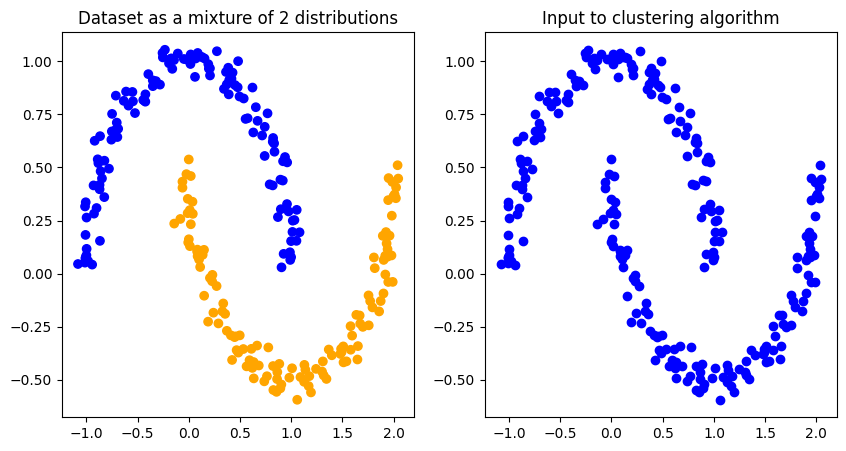

In [ ]:
fig, [ax1, ax2] = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

colors = np.array(['blue', 'orange'])

ax1.set_title('Dataset as a mixture of 2 distributions')
ax1.scatter(X[:,0], X[:,1], c=colors[Y])

ax2.set_title('Input to clustering algorithm')
ax2.scatter(X[:,0], X[:,1], c=colors[0])

plt.show()

As you can see, the dataset is a mixture of some 2 non-linear distributions. We would naturally want them to be clustered as on the left picture. However, we don't know the parameters of the distribution and receive the dataset as a collections of points (the right picture)

##<font color="red">Task 1.1: K-means (0.2 pts)</font></h2>

Why bother with spectral clustering? Indeed, we know k-means, why not to use it?

* Train k-means classifier with 2 clusters. Visualize and comment on its results.
* Did it perform well? What are the necessary conditions of input data for k-means clustering to show good results? (2 sentences max)

**Note:** no need to write k-means by hand, clustering can be done with 1 line of code :)

**P.S.** you might want to use ```sklearn.cluster.KMeans```

**P.S.** [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) is a good comparison of various clustering algorithms on different datasets. Take a look at ```MiniBatch KMeans``` (which is a slight modification of kmeans).

---
#### YOUR CODE AND EXPLANATIONS BELOW

K-means algorithm didn't perform well to cluster this dataset, since it is trying to minimize the variance within a cluster.

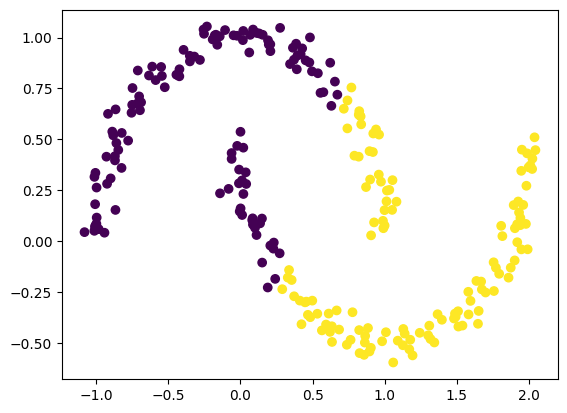

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)

kmeans.fit(X)
y_pred = kmeans.predict(X)

plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.show()

## Spectral Clustering References

Before talking about spectral clustering, here are the references that could help you to understand it better:

* Kevin P. Murphy. Probabilistic Machine Learning: An Introduction, MIT, 2022. Section 21.5 https://probml.github.io/pml-book/book1.html
* Ulrike von Luxburg. A Tutorial on Spectral Clustering. https://arxiv.org/pdf/0711.0189.pdf

## Similarity and Weights Matrix

Spectral clustering is based on the notion of *similarity* $s_{ij} \geq 0$ between data points (with close points having high similarity and distant points having low similarity).

Based on similarities, we form a **weight matrix** $W$, which is then passed to the spectral clustering algorithm. One important note is that $W$ needs to model the local neighborhood relationships between the data points (it also need to satisfy $W_{ij} \geq 0$ and $W_{ij} = W_{ji}$ for every $i,j$).

There are a few ways to construct a **weight matrix**:

1. **$\epsilon$-neighbourhood**. We say that

$
\begin{equation}
  \quad \quad W_{ij}=\begin{cases}
    1, & \text{if $\lVert X_i - X_j \rVert < \epsilon$},\\
    0, & \text{otherwise}.
  \end{cases}
\end{equation}
$

2. **$k$-nearest neighbor**. We say that $W_{ij} = 1$ if $i$ is among $k$ nearest neighbors of $j$ or vice versa (to make this relation symmetric), and $0$ otherwise

3. **Gaussian similarity**. We say that $W_{ij} = e^{- \gamma \lVert X_i - X_j \rVert ^2}$ (with $\gamma \geq 1$)


**P.S.** In case you need a more thorough explanation, please read ```Section 2``` of [A Tutorial on Spectral Clustering](https://arxiv.org/pdf/0711.0189.pdf), which covers this in much greater detail

## Visualizing the Epsilon Neighbourhood

Here is an example of $\epsilon$-neighborhood for $\epsilon = 0.15$:

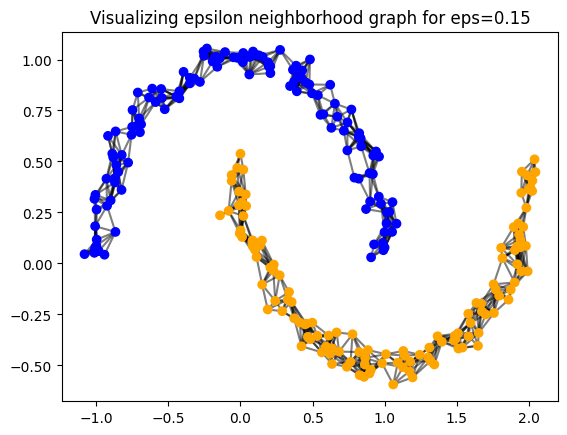

In [ ]:
eps = 0.15

plt.figure()
plt.title('Visualizing epsilon neighborhood graph for eps=%s' % (eps))

for i in range(X.shape[0]):
    for j in range(i + 1, X.shape[0]):
        d = math.sqrt(np.sum((X[i] - X[j]) ** 2))
        if d <= eps:
            plt.plot((X[i,0], X[j,0]), (X[i,1], X[j,1]), zorder=-1, c='black', alpha=0.5)

plt.scatter(X[:,0], X[:,1], c=colors[Y], zorder=1)
plt.show()

## Understanding Gaussian Similarity

As you can see from the previous picture, the **$\epsilon$-neighbourhood** weight matrix is actually the graph, which models the neighbourhood relation between the data points (same is true for **$k$-nearest neighbor** weight matrix).

However, with **Gaussian similarity** the graph becomes fully connected, i.e. all edges have some positive weight. If you think about the formula, you'll see that close points will get values close to $1$, while distant points will get the values close to $0$ (with exponential decay). Note that with increasing gamma, the function becomes even more steep:

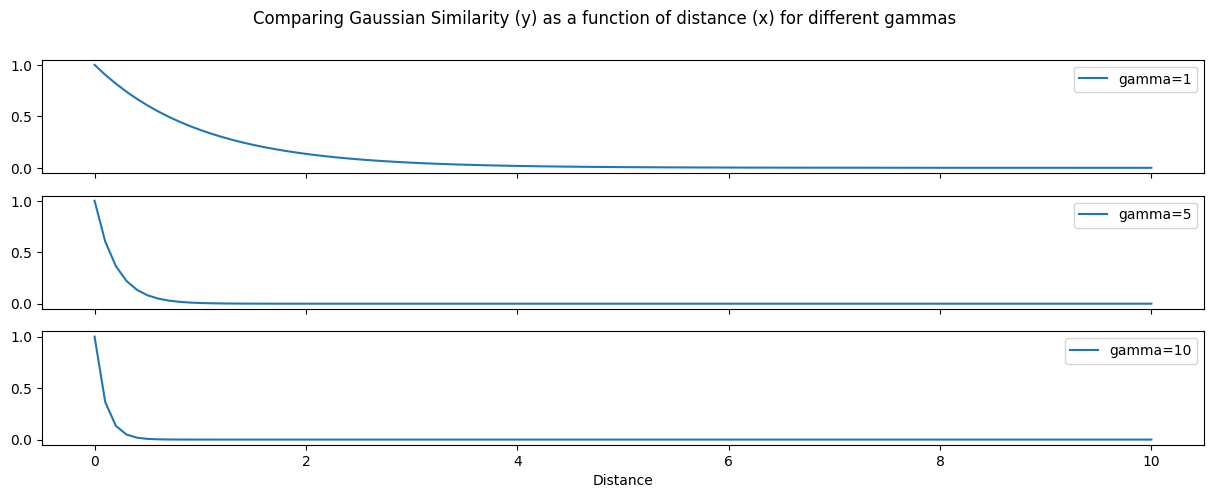

In [ ]:
fig, axis = plt.subplots(figsize=(15, 5), nrows=3, ncols=1, sharex=True, sharey=True)
gammas = [1, 5, 10]

assert len(axis) == len(gammas)

x = np.linspace(0, 10, 100)

for ax, gamma in zip(axis, gammas):
    y = np.exp(-gamma * x)
    ax.plot(x, y, label='gamma=%s' % (gamma, ))
    ax.legend()

fig.suptitle('Comparing Gaussian Similarity (y) as a function of distance (x) for different gammas')
axis[-1].set_xlabel('Distance')

plt.show()

##<font color="red">Task 1.2 Calculating Gaussian Similarity (0.3 pts)</font></h2>

* write a function for calculating **Gaussian Similarity** weights matrix for the given input data

**Note:** in ```sklearn``` documentation on spectral clustering:
* **Gaussian Similarity** $\approx$ **rbf kernel**
* **Weights matrix** is identical to **affinity matrix**

In [ ]:
def rbf_affinity_matrix(X: np.array, gamma: float) -> np.array:
    """
    Parameters
    ----------
    X : np.array of shape (N, M)
         Input data (N - number of samples, M - number of features (in our case it's 2))

    gamma: float
    ----------

    Returns
    ----------
    np.array of shape (N, N) - rbf affinity matrix
    ----------
    """
    N = X.shape[0]
    affinity_matrix = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            distance_sq = np.sum((X[i] - X[j]) ** 2)
            affinity_matrix[i, j] = np.exp(-gamma * distance_sq)

    return affinity_matrix

In [ ]:
# test code
for gamma in range(1, 15, 2):
    expected_affinity = sklearn.cluster.SpectralClustering(n_clusters=2, affinity='rbf', gamma=gamma).fit(X).affinity_matrix_
    actual_affinity = rbf_affinity_matrix(X, gamma)

    assert expected_affinity.shape == actual_affinity.shape, 'Wrong affinity matrix shape, expected %s, got %s (gamma=%s)' % (expected_affinity.shape, actual_affinity.shape, gamma)
    assert np.sum(np.abs(expected_affinity - actual_affinity) > 1e-6) == 0, 'Some RBF affinity matrix values are wrong (gamma=%s)' % (gamma, )

## Laplacian Matrix

Actually, spectral clustering works not with affinity matrix, but with the **Laplacian** matrix, which is defined as follows:

$D$ &mdash; degree matrix (diagonal), $D_{ii} = \sum\limits_j A_{ij}$ (where $A$ is affinity matrix)

$L$ &mdash; unnormalized laplacian, $L = D - A$

$L_{sym}$ &mdash; normalized Laplacian, $L_{sym} = D^{-1/2} L D^{-1/2}$, with $D^{-1/2}$ being a diagonal matrix with $D^{-1/2}_{ii} = \frac{1}{\sqrt{D_{ii}}}$

## Laplacian Properties

**Note:** this is very closely related to ```Section 3.1``` of [A Tutorial on Spectral Clustering](https://arxiv.org/pdf/0711.0189.pdf)

Despite seeming artificial, Laplacian $L$ (and $L_{sym}$) has some nice properties:

1. For every vector $f \in \mathbb{R}^n$:

    $f^TLf = \frac{1}{2}\sum\limits_{i,j=1}^{n} w_{ij}(f_i - f_j)^2 \tag{1}$
2. Because $w_{ij} \geq 0$, $L$ is positive semi-definite (previous equation is literally the definition)
3. $L$ is symmetric
4. From 2. and 3. we conclude that the eigenvalues of $L$ are non-negative
5. Eq. (1) can be used to show that the multiplicity of eigenvalue $0$ of $L$ is equal to the number of connected components in the weighted graph $G$ of the input data. Basically, it shows that the corresponding eigenfunctions assume constant values on every conected component of $G$

## Some explanations

In these notes, we interpret the datapoints as vertices of a weighted graph $G$, with edge weights coming from the affinity matrix $A$.

### Step 1
Assume for the time being that the graph $G$ is disconnected and consists of two connected components, $G = G_1 \cup G_2$. Let $n$, $n_1$, and $n_2$ be the cardinalities (numbers of vertices) of $G$, $G_1$, and $G_2$ respectively. Now order the vertices so that those in $G_1$ are listed first. Then the corresponding Laplacian $L$ is block diagonal, $L=L_{11}\oplus L_{22}$, with $L_{jj}$ being the Laplacian of the subgraph $G_j$. Therefore, the nullspace of $L$ is two-dimensional, and the basis can be chosen of the form $\mathbf{u}_1 = (v_1, 0)$ and $\mathbf{u}_2 = (0, w_2)$, with arbitrary constants $v_1$ and $w_2$. Form an $n\times 2$ matrix $U$ composed of the columns $\mathbf{u}_1$ and $\mathbf{u}_2$; then the first $n_1$ rows of $U$ are $(v_{1}, 0)$, while the last $n_2$ rows have the form $(0,w_{2})$. This helps to cluster the vertices of $G$ in a very simple way using the rows of $U$.

### Step 2.
Assume now that $G$ is connected but the components $G_1$ and $G_2$ are weakly-connected, i.e., the affinity of any vertex of $G_1$ and any vertex of $G_2$ is smaller than within $G_1$ or $G_2$. Then the off-diagonal blocks $L_{12}$ and $L_{21}$ of the Laplacian $L$ are small, so that $L$ can be considered as a small perturbation of the block-diagonal part $L_0:=L_{11}\oplus L_{22}$, and both the eigenvalues and eigenvectors of $L$ are close to those of $L_0$. Therefore, the lowest two eigenvalues of $G$ have eigenvectors of the form $\mathbf{u}_1 = (v_1,w_1)$ and $\mathbf{u}_2 = (v_2,w_2)$ with small components $w_1$ and $v_2$. As a result, in the first $n_1$ rows $(v_{1j}, v_{2j})$ of the matrix $U$ the second components $v_{2j}$ are much smaller than the first components $v_{1j}$, while in the last $n_2$ rows $(w_{1j},w_{2j})$ the second components dominate. As before, we see that the rows of $U$ can be used to cluster components $G_1$ and $G_2$ in a very efficient way.

### Step 3.
In general, the order of the vertices of $G$ is arbitrary; however, if we find the eigenvectors corresponding to two lowest eigenvalues of the Laplacian $L$, form the matrix $U$, normalize its rows, and then perform **$2$-means** clustering of these rows, then one cluster will consist of rows with dominating first entry, and the other of rows with dominating second entries. These clusters suggest clustering of the vertices of $G$ into parts $G_1$ and $G_2$ with small affinity between $G_1$ and $G_2$.

### Step 4.
Clearly, the same arguments give justification of the spectral clustering algorithm when we try to split $G$ into $k$ components. Also, they work for the symmetrized Laplacian $L_{sym}$.

**P.S.** In case you need more details, look at ```Section 3``` from [A Tutorial on Spectral Clustering](https://arxiv.org/pdf/0711.0189.pdf)

##<font color="red">Task 1.3 Calculating Normalized Laplacian (0.2 pts)</font>

Write a function for calculating the normalized Laplacian from the affinity matrix

In [ ]:
def normalized_laplacian(affinity_matrix: np.array) -> np.array:
    """
    Parameters
    ----------
    affinity_matrix : np.array of shape (N, N)
    ----------

    Returns
    ----------
    np.array of shape (N, N) - normalized Laplacian for the given affinity matrix
    ----------
    """
    assert len(affinity_matrix.shape) == 2, 'Expected affinity matrix to be 2d array'
    assert affinity_matrix.shape[0] == affinity_matrix.shape[1], 'Expected affinity matrix to be square'
    assert affinity_matrix.shape[0] > 0, 'Too few entries in affinity matrix'
    assert np.sum(np.abs(affinity_matrix - np.transpose(affinity_matrix)) > 1e-6) == 0, 'affinity matrix is not symmetric, sth went wrong in previous steps'

    N = affinity_matrix.shape[0]

    degree_matrix = np.diag(np.sum(affinity_matrix, axis=1))
    degree_matrix_inv_sqrt = np.linalg.inv(np.sqrt(degree_matrix))
    laplacian = np.eye(N) - degree_matrix_inv_sqrt @ affinity_matrix @ degree_matrix_inv_sqrt
    return laplacian

In [ ]:
expected_L_sym = scipy.sparse.csgraph.laplacian(rbf_affinity_matrix(X, gamma=1), normed=True)
actual_L_sym = normalized_laplacian(rbf_affinity_matrix(X, gamma=1))

# compare expected_L_sym with actual_L_sym (values can be a bit different)

In [ ]:
expected_L_sym

array([[ 1.00000000e+00, -3.72732418e-03, -4.28360898e-03, ...,
        -4.12815077e-03, -3.94860563e-03, -4.65845402e-03],
       [-3.72732418e-03,  1.00000000e+00, -3.72500737e-04, ...,
        -3.35877760e-04, -6.12040221e-03, -3.53828751e-04],
       [-4.28360898e-03, -3.72500737e-04,  1.00000000e+00, ...,
        -1.31846024e-02, -2.57014232e-04, -1.27768747e-02],
       ...,
       [-4.12815077e-03, -3.35877760e-04, -1.31846024e-02, ...,
         1.00000000e+00, -2.37259547e-04, -1.30034788e-02],
       [-3.94860563e-03, -6.12040221e-03, -2.57014232e-04, ...,
        -2.37259547e-04,  1.00000000e+00, -3.23813446e-04],
       [-4.65845402e-03, -3.53828751e-04, -1.27768747e-02, ...,
        -1.30034788e-02, -3.23813446e-04,  1.00000000e+00]])

In [ ]:
actual_L_sym

array([[ 9.90542281e-01, -3.69222187e-03, -4.23578205e-03, ...,
        -4.08139834e-03, -3.90701762e-03, -4.60544692e-03],
       [-3.69222187e-03,  9.90622596e-01, -3.68356661e-04, ...,
        -3.32087315e-04, -6.05618564e-03, -3.49816824e-04],
       [-4.23578205e-03, -3.68356661e-04,  9.87130460e-01, ...,
        -1.30128144e-02, -2.53868929e-04, -1.26097179e-02],
       ...,
       [-4.08139834e-03, -3.32087315e-04, -1.30128144e-02, ...,
         9.86810693e-01, -2.34318038e-04, -1.28312786e-02],
       [-3.90701762e-03, -6.05618564e-03, -2.53868929e-04, ...,
        -2.34318038e-04,  9.88394233e-01, -3.19781577e-04],
       [-4.60544692e-03, -3.49816824e-04, -1.26097179e-02, ...,
        -1.28312786e-02, -3.19781577e-04,  9.86704066e-01]])

## Spectral clustering algorithm

At this point, we can finally formulate the spectral clustering algorithm.

In order to do spectral clustering with $k$ clusters for the dataset $X$:

1. compute the affinity matrix $A$ of the input data $X$
2. compute normalized Laplacian ($L_{sym}$)
3. find the first $k$ eigenvectors of $L_{sym}$ (i.e. eigenvectors that correspond to $k$ smallest eigenvalues)
4. construct matrix $U \in \mathbb{R}^{N \times k}$ with the columns being eigenvectors from 3. (i.e. $U = [v_1, v_2, ... v_k]$)  
5. normalize the rows $y_i$ of $U$
6. run k-means clustering for points $y_i$

The labels of kmeans clustering in 6. give the cluster labels in the original dataset $X$

**Note:** no need to calculate eigenvalues/eigenvectors by hand

**Note:** no need to do k-means clustering by hand

**Note:** make sure you instruct your solver to find the smallest eigenvalues. For example, you can use:
```python
    # L_sym = ...
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(L_sym, k=n_clusters, which='SM')
    # which = 'SM', meaning find k smallest eigenvalues
```

##<font color="red">Task 1.4 Spectral Clustering Algorithm (0.7 pts)</font>

Implement a function that does spectral clustering

In [ ]:
from scipy.linalg import eigh

def spectral_clustering(X: np.array, affinity_fn: Callable[[np.array], np.array], n_clusters: int) -> np.array:
    """
    Parameters
    ----------
    X : np.array of shape (N, M)
         Input data (N samples, M features (in our case M=2))

    affinity_fn: Callable[[np.array], np.array]
         Function to calculate affinity from the input data

    n_clusters : int
         Number of clusters to partition X into
    ----------

    Returns
    ----------
    np.array of shape (N, ) with labels assigned to X
    ----------
    """
    affinity_matrix = affinity_fn(X)
    laplacian_matrix = normalized_laplacian(affinity_matrix)

    eigenvalues, eigenvectors = eigh(laplacian_matrix)
    X_laplacian = eigenvectors[:, :n_clusters]
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_laplacian)

    return kmeans.labels_

##<font color="red">Task 1.5 Explore hyperparameter space (0.3 pts)</font>

1. Run the spectral clustering algorithm for the dataset introduced above with different parameters:
    * try different values of gamma for **rbf** affinity matrix (e.g. 1, 5, 10, 20)
    * try different values of epsilon for **epsilon-neighbourhood** affinity matrix (you'll need to implement it)
2. Visualize and comment on the results you observed


For the rdf affinity matrix the better results where achieved with higher gamma, meanwhile the epsilon-neighbourhood matrix worked better with smaller epsilon value.

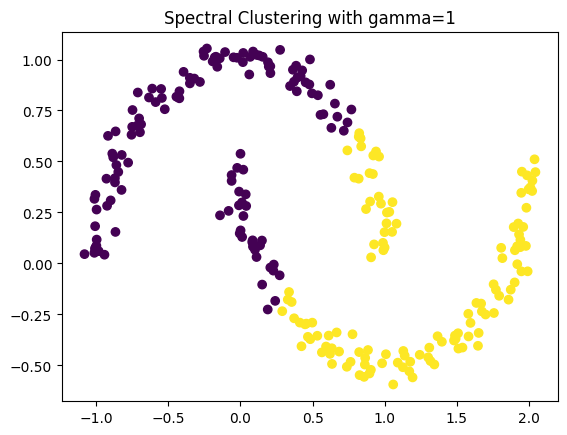

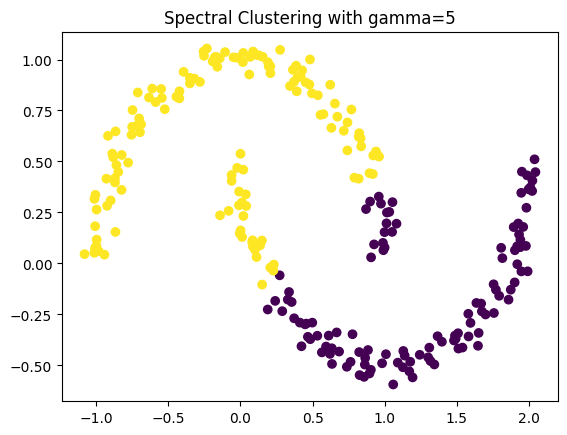

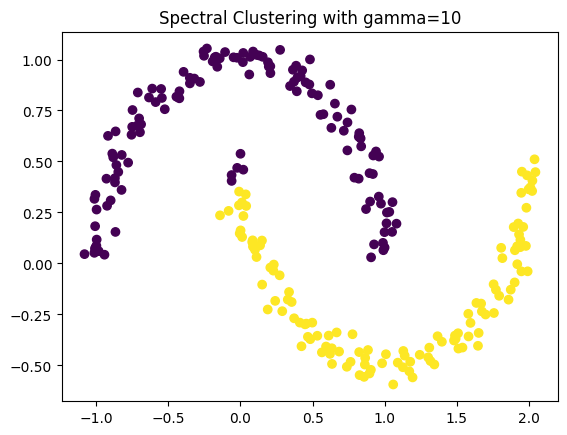

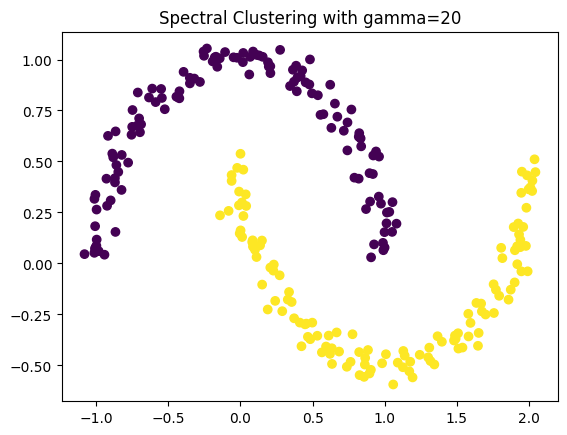

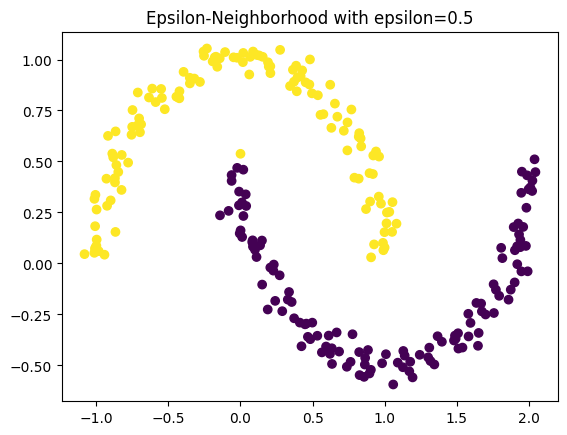

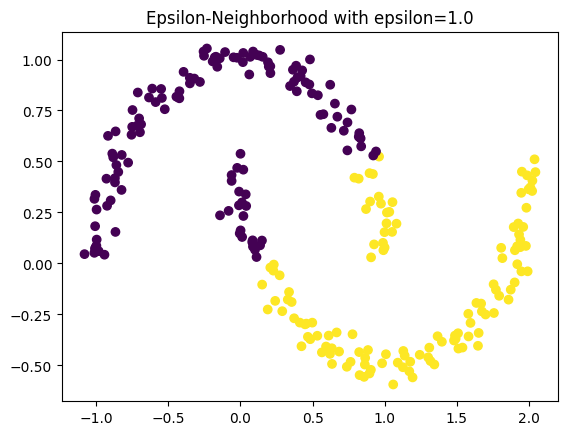

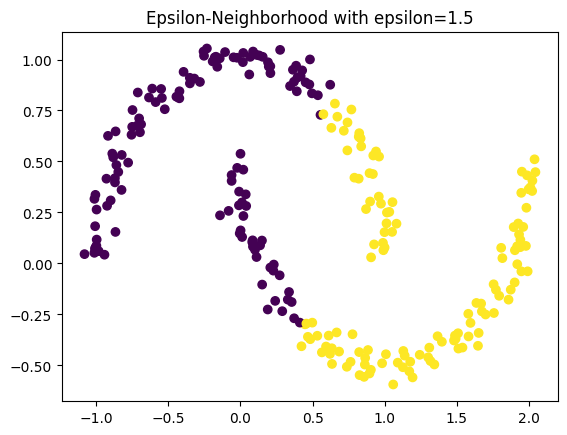

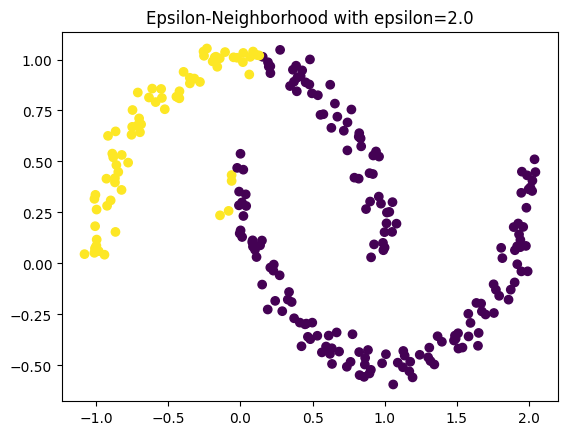

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def epsilon_affinity_matrix(X: np.array, epsilon: float) -> np.array:
    distances = euclidean_distances(X)
    affinity_matrix = (distances <= epsilon).astype(int)
    return affinity_matrix

def plot_clusters(X: np.array, labels: np.array, title: str):
    plt.scatter(X[:, 0], X[:, 1], c=labels)
    plt.title(title)
    plt.show()

gamma_values = [1, 5, 10, 20]
for gamma in gamma_values:
    labels = spectral_clustering(X, lambda X: rbf_affinity_matrix(X, gamma), n_clusters=2)
    plot_clusters(X, labels, f'Spectral Clustering with gamma={gamma}')

epsilon_values = [0.5, 1.0, 1.5, 2.0]
for epsilon in epsilon_values:
    labels = spectral_clustering(X, lambda X: epsilon_affinity_matrix(X, epsilon), n_clusters=2)
    plot_clusters(X, labels, f'Epsilon-Neighborhood with epsilon={epsilon}')

#2. Multidimensional Scaling (1.3 pts)

Metric Multidimensional Scaling (Metric MDS), also known as classical multidimensional scaling, is a technique used for dimensionality reduction, primarily for visualization purposes. It aims to represent data in a lower-dimensional space while preserving the distances between data points as accurately as possible.

Given is a dataset $\mathbf{x}_1, \dots, \mathbf{x}_n$ of points in $\mathbb{R}^N$ with large $N$. The task is to find points $\mathbf{y}_1, \dots, \mathbf{y}_n$, representing the data in a lower-dimensional space $\mathbb{R}^d$ (typically $d=2$ or $d=3$ for visualization purposes), such that $$\|\mathbf{y}_i - \mathbf{y}_j\| \approx d_{ij}:=\|\mathbf{x}_i - \mathbf{x}_j\|,$$
and the approximation is as good as possible.

The MDS algorithm suggests that the points $\mathbf{y}_1, \dots, \mathbf{y}_n$ are the properly scaled rows of a matrix $V$ of size $n\times d$ whose columns are eigenvectors of the Gram matrix $G$ of the points $\mathbf{x}_1, \dots, \mathbf{x}_n$ corresponding to its $d$ largest eigenvalues. Two observations are that
- the Gram matrix $(G)_{i,j} = \mathbf{x}_i^\top \mathbf{x}_j$ is uniquely determined by the distance matrix $D$
- the above choice of $\mathbf{y}_i$ is optimal in the sense that the Gram matrix $G_{\mathbf{y}}$ of the points $\mathbf{y}_i$ is the closest possible one to $G$ in the Frobenius norm

We justify these claims in the notes below



### Gram matrix

First observation that the distance matrix is shift invariant, so that without loss of generality, we assume that the points $\{\mathbf{x}_i\}_{i=1}^n$ are centered, i.e.,
$$ \sum_{i} \mathbf{x}_i = \mathbf{0} \tag1
$$

Our next observation is that under the above assumption, the distances $d_{ij}$ completely determine the Gram matrix $G = X^\top X$ of the points $\mathbf{x}_i$; here $X$ is the $N \times n$ matrix whose columns are $\mathbf{x}_i$. Indeed,
$$
  d_{ij}^2 = \|\mathbf{x}_i - \mathbf{x}_j\|^2  = \|\mathbf{x}_i\|^2 - 2 \mathbf{x}_i^\top \mathbf{x}_j + \|\mathbf{x}_j\|^2 \tag2
$$
and summing over $i$ on account of (1) we get
$$
  \|\mathbf{x}_j\|^2 = d_{\cdot j}^2 - S \tag3
$$
where
$$
   d_{\cdot j}^2 = \frac1n\sum_i d_{ij}^2, \qquad
   S:= \frac1n \sum_i \|\mathbf{x}_i\|^2
$$
Summing (3) over $j$ results in
$$
  S = \frac1{2} d_{\vphantom{j}\cdot\cdot}^2 := \frac1{2n^2} \sum_{i,j} d_{ij}^2
$$
Thus we get from (3) that
$$
  \|\mathbf{x}_i\|^2 = d^2_{\cdot j} - \frac12 d_{\vphantom{j}\cdot\cdot}^2
$$
and thus, from (2),  
$$
    d_{ij}^2 - d^2_{\cdot j} - d^2_{i\cdot} + d_{\vphantom{j}\cdot\cdot}^2 = -2 \mathbf{x}_i^\top \mathbf{x}_j
$$

### Double centering

Denote by $\mathbf{1}$ the column vector of ones and observe that
$$
  \frac1n  \mathbf{1}^\top D^{(2)} =  (d_{\cdot 1}^2,\,  d_{\cdot 2}^2,\, \dots,\, d_{\vphantom{j}\cdot n}^2), \qquad
  \frac1n D^{(2)} \mathbf{1}  =  (d_{1\cdot }^2,\,  d_{2\cdot}^2,\, \dots,\, d_{\vphantom{j}n\cdot}^2)^\top, \qquad
  \frac1{n^2} \mathbf{1}^\top D^{(2)} \mathbf{1} = d_{\vphantom{j}\cdot\cdot}^2
$$
Therefore, the Gram matrix $G$ can be found from the relation
$$
  -2G = D^{(2)} - \frac1n \mathbf{1} \mathbf{1}^\top D^{(2)}
    - \frac1n D^{(2)}\mathbf{1} \mathbf{1}^\top
    + \frac1{n^2} \mathbf{1}\mathbf{1}^\top D^{(2)} \mathbf{1}\mathbf{1}^\top
$$
Upon introducing
 $J := I - \frac{1}{n}\mathbf{1}\mathbf{1}^\top$,
we rewrite the above representation as
$$
  G = -\frac12 J D^{(2)} J \tag4
$$




### Optimal choice

We look for the $d$-dimensional vectors $\mathbf{y}_i$, $i=1,2,\dots,n$, such that the scalar products $\mathbf{y}_i^\top \mathbf{y}_j$ are as close to $G_{ij}$ as possible. In other words, we want the Gram matrix $Y^\top Y$ (that has rank at most $d$) as close to $G$ in the Frobenius norm as possible; here $Y$ is $d\times n$ and has $j^{\mathrm{th}}$ column equal to $\mathbf{y}_j$.

As is well known, the best rank-$d$ approximation to a positive semidefinite matrix $G$ is given by via spectral decomposition: if $\lambda_1 \ge \lambda_2 \ge \dots \ge \lambda_n \ge0$ are eigenvalues of $G$ and $\mathbf{v}_1$, $\mathbf{v}_2, \dots, \mathbf{v}_n$ the corresponding normalized eigenvectors, then the best approximation is
$$
  G_k := \lambda_1 \mathbf{v}_1\mathbf{v}^\top_1 + \lambda_2 \mathbf{v}_2\mathbf{v}^\top_2 + \dots + \lambda_d \mathbf{v}_d\mathbf{v}^\top_d
  = V_d \Lambda_d V_d^\top
$$
where $V_d$ is the $n\times d$ matrix with columns $\mathbf{v}_1$, $\mathbf{v}_2, \dots, \mathbf{v}_d$ and $\Lambda_d$ is the $d\times d$ diagonal matrix with $\lambda_1, \lambda_2, \dots, \lambda_d$ on the diagonal.  

This suggests taking $Y = \Lambda_d^{1/2} V_d^\top$; in other words, $\mathbf{y}_j$ is the $j^{\mathrm{th}}$ row of $V_d$ scaled by $\lambda_j^{1/2}$.


### MDS vs PCA

We observe that if the initial distance matrix $D$ comes from the actual Euclidean distances, $d_{ij} = \|\mathbf{x}_i - \mathbf{x}_j\|_2$, then the MDS coincides with PCA.
- Indeed, we start with the SVD of $X$, $X = U \Sigma V^\top$; here $U$ is $N \times N$ whose columns are eigenvectors of $XX^\top$, $\Sigma$ is of size $N \times n$ with singular values $\sigma_j = \lambda_j^{1/2}$ on the diagonal, and $V$ is $n\times n$ with columns that are eigenvectors of $X^\top X$.
- MDS is based on the Gram matrix $G$ of size $n\times n$ of the data points $\mathbf{x}_i$, so that $G = X^\top X = V \Sigma^\top \Sigma V^\top$
- PCA starts with the covariance matrix $XX^\top$  of size $N \times N$, i.e., $XX^\top = U \Sigma \Sigma^\top U^\top$. Columns $\mathbf{u}_1, \dots, \mathbf{u}_N$ of $U$ are the principal components. The original coordinates of $\mathbf{x}_j$ are then changed to those in the basis  $\mathbf{u}_j$, i.e., to $U^\top \mathbf{x}_j$
- Therefore, PCA transformation of the dataset $\mathbf{x}_j$ to dimension $d$ takes the form $U_d^\top X = U_d^\top U \Sigma V^\top$ and is of size $d \times n$, i.e., the columns of that matrix are the reduced coordinates of the data points $\mathbf{x}_j$. Since $U_d^\top U \Sigma = (\Lambda^{1/2}_d \mid 0)$ of size $d \times n$, we conclude that
$
  U_d X = U_d^\top U \Sigma V^\top
$
has $d$ rows that are $\lambda_j^{1/2}$-scaled columns of $V$, and the PCA-projected points are the $n$ columns of that matrix. By comparing with the above, we conclude that these are the same points $\mathbf{y}_j$ as produced by the MDS.


### Why MDS?

MDS is often used to represent (complete) weighted graphs, in which the weights do not necessarily are related to any distances between the vertices of $G$, which need not be points of $\mathbb{R}^N$ at all. We then take the weights $w_{ij}$ as "distances" $d_{ij}$.

Observe that in that case the matrix $G$ of (4) need not be positive semi-definite; however, we still can use the largest $d$ eigenvalues and the corresponding eigenvectors to construct the $d$-dimensional immersion of the graph so that the Euclidean distances between $\mathbf{y}_i$ and $\mathbf{y}_j$ are as close to the weights $w_{ij}$ as possible.

Also, even if we start with the actual $N$-dimensional points $\mathbf{x}_i$, the distances $\|\mathbf{x}_i - \mathbf{x}_j\|$ between the points can be measured w.r.t. any distance, e.g., the cosine or maximum or Manhatten ones. In that case, too, the outcome of MDS will be different from that of PCA.

##<font color="red">Task 2.1 Metric Multidimensional Scaling Algorithm Implementation (0.7 pt)</font>

In order to do implement Metric Multidimensional Scaling Algorithm for the dataset $X$:
1. Calculate Distance Matrix: Metric MDS starts with a matrix of distances $D$ between every pair of points in the dataset. This matrix is typically calculated using a distance metric like the Euclidean distance. The element $ d_{ij} $​ of $D$ represents the distance between the points $\mathbf{x}_i$ and $\mathbf{x}_{j}$ in $\mathbb{R}^D$.

2. Perform Double Centering and Squaring the Distance Matrix: The distance matrix $D$ is transformed into the Gram matrix $G$ that can be used for eigen decomposition. This involves squaring the distances and then applying double centering:
 * Squared Distance Matrix: $D^{(2)}$, where each element is $d_{ij}^2 $
 * Double Centering: $G = -\frac{1}{2}JD^{(2)}J $, where $J$ is a centering matrix defined as $J = I - \frac{1}{n}\mathbf{1}\mathbf{1}^\top$ with $I$ being the identity matrix and $\mathbf{1}$ a vector of ones.

3. Perform Eigen Decomposition of the matrix $G$: To this end, find the eigenvalues $\lambda_j$ and the corresponding normalized eigenvectors $\mathbf{v}_j$ of $G$, form an orthogonal matrix $V$ with columns $\mathbf{v}_j$ and a diagonal matrix $\Lambda$ with diagonal entries $\lambda_j$:
$$
 G = V \Lambda V^\top
$$

4. Choosing Dimensions and Constructing the Low-Dimensional Representation: The eigenvalues are sorted in descending order. The $d$ largest eigenvalues form a $d\times d$ diagonal matrix $\Lambda_d$, the corresponding eigenvectors form an $n\times d$ matrix $V_d$, and the vectors $\mathbf{y}_j$ are rows of $\Lambda_d^{1/2}V_d^\top$

In [ ]:
digits_dataset = sklearn.datasets.load_digits()
X, y = digits_dataset.data, digits_dataset.target

In [ ]:
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


In [ ]:
# for better visualization use only three digits (of your choice)
selected_digits = [3, 5, 6]

mask = np.isin(y, selected_digits)
X = X[mask]
y = y[mask]

In [ ]:
def compute_distance_matrix(X):
    """
    Computes the pairwise Euclidean distance matrix for a given dataset.

    Parameters:
    X (array-like): A two-dimensional numpy array where each row represents an individual data point.

    Returns:
    numpy.ndarray: A two-dimensional numpy array representing the pairwise Euclidean distance matrix.
    """

    N = X.shape[0]
    distance_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1, N):
            diff = X[i] - X[j]
            distance = np.sqrt(np.sum(diff ** 2))
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    return distance_matrix


def double_centering(D):
    """
    Performs double centering on a given distance matrix.

    Double centering is a transformation that modifies the distance matrix by subtracting row means,
    column means, and adding the overall mean. This step is necessary for Metric Multidimensional Scaling.

    Parameters:
    D (numpy.ndarray): The square matrix representing pairwise distances.

    Returns:
    numpy.ndarray: The double centered matrix B.
    """

    N = D.shape[0]
    row_means = np.mean(D, axis=1, keepdims=True)
    col_means = np.mean(D, axis=0, keepdims=True)
    mean = np.mean(D)

    return D - row_means - col_means + mean


def eigen_decomposition(B, n_components):
    """
    Performs eigen decomposition on the double centered matrix and extracts the top 'n_components' eigenvectors.

    Parameters:
    B (numpy.ndarray): The double centered matrix.
    n_components (int): The number of components (dimensions) to be used in the reduced space.

    Returns:
    tuple: A tuple containing the top 'n_components' eigenvalues and their corresponding eigenvectors.
    """
    covariance_matrix = np.cov(B.T)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_eigenvalues = eigenvalues[sorted_indices][:n_components]
    top_eigenvectors = eigenvectors[:, sorted_indices][:, :n_components]

    return top_eigenvalues, top_eigenvectors


def mds(X, n_components=2):
    """
    Performs Multidimensional Scaling (MDS) on a given dataset.

    This function computes the distance matrix, applies double centering, and then uses eigen decomposition
    to project the data into a lower-dimensional space.

    Parameters:
    X (array-like): A two-dimensional numpy array where each row represents an individual data point.
    n_components (int, optional): The number of dimensions for the reduced space (default is 2).

    Returns:
    numpy.ndarray: A two-dimensional numpy array where each row is the projection of the original data
    points into the reduced space.
    """
    distance_matrix = compute_distance_matrix(X)
    centered_matrix = double_centering(distance_matrix)
    eigenvalues, eigenvectors = eigen_decomposition(centered_matrix, n_components)
    projected_data = eigenvectors @ np.diag(np.sqrt(eigenvalues))

    return projected_data

In [ ]:
custom_mds = mds(X, n_components=2)

<ipython-input-24-22e7f4cf9e7b>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(custom_mds[:, 0], custom_mds[:, 1], c=y, cmap=plt.cm.get_cmap("jet", 4))


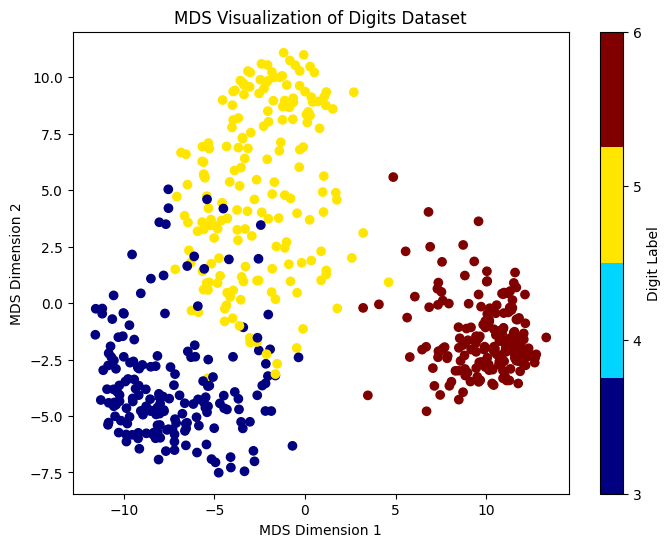

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(custom_mds[:, 0], custom_mds[:, 1], c=y, cmap=plt.cm.get_cmap("jet", 4))
plt.colorbar(label='Digit Label', ticks=range(10))
plt.title("MDS Visualization of Digits Dataset")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.show()

##<font color="red">Task 2.2 MDS vs PCA (0.2 pt)</font>

Another algorithm for dimenionality reduction is PCA. Both PCA and MDS use eigen decomposition as a core part of their algorithms. In PCA, eigen decomposition is applied to the covariance matrix (or correlation matrix) of the data. The eigenvectors (principal components) are the directions in which the data varies the most, and the $d$-dimensional representations of the data points $\mathbf{x}_j$ are their orthogonal projections onto the $d$-dimensional spectral subspace spanned by the eigenvectors with the $d$ largest eigenvalues.

In the classical MDS, eigen decomposition is applied to the same matrix (derived from the distance matrix as explained above), and the eigenvectors are used to construct the new representation of the data in the reduced space in a non-trivial way.

Let's run the PCA on the same dataset and compare the results.

<ipython-input-25-32eee314f4b5>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.get_cmap('jet', 4))


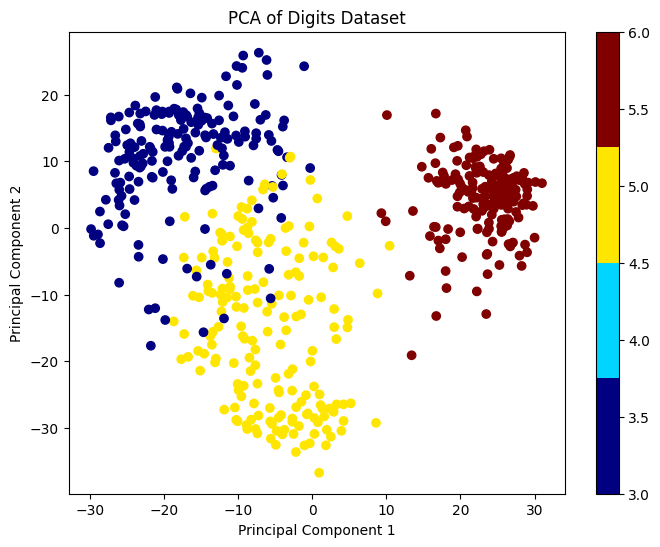

In [ ]:
pca = sklearn.decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.get_cmap('jet', 4))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.title('PCA of Digits Dataset')
plt.show()

It can make sense to apply PCA before MDS in certain situations, depending on your specific goals and the characteristics of your data. PCA is primarily used to reduce the dimensionality of data while preserving as much variance as possible. By discarding the least important principal components (which represent noise or less important information), you can reduce the impact of noisy or irrelevant features on your MDS results. This can lead to a cleaner and more meaningful representation of the data.

<ipython-input-27-3379e7ba1833>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(custom_mds_pca[:, 0], custom_mds_pca[:, 1], c=y, cmap=plt.cm.get_cmap("jet", 4))


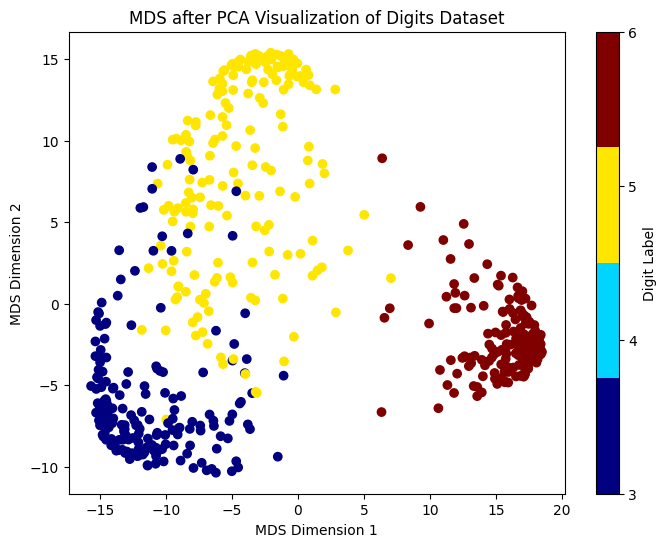

In [ ]:
pca = sklearn.decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X)

custom_mds_pca = mds(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(custom_mds_pca[:, 0], custom_mds_pca[:, 1], c=y, cmap=plt.cm.get_cmap("jet", 4))
plt.colorbar(label='Digit Label', ticks=range(10))
plt.title("MDS after PCA Visualization of Digits Dataset")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.show()

##<font color="red">Task 2.3 Measure of clustering (0.2 pt)</font>

The Calinski-Harabasz Index, also known as the Variance Ratio Criterion, is a method for evaluating the quality of a clustering (especially in Fischer LDA). It is an internal evaluation metric, meaning it doesn't require external information like true labels and is based solely on the data itself.

The Calinski-Harabasz Index is designed to measure the dispersion between clusters and the dispersion within clusters. The basic idea is that a good clustering will have tight clusters (meaning low intra-cluster variance) and well-separated clusters (meaning high inter-cluster variance).

The index is defined as the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters, where the dispersion is measured as the sum of squared distances. Mathematically, it is given as:
$$CH = \frac{{BSS}/{(k - 1)}}{{WSS}/{(n - k)}}$$
where:
* $BSS$ is the between-cluster sum of squares (measuring the dispersion between clusters),
* $WSS$ is the within-cluster sum of squares (measuring the dispersion within clusters),
* $k$ is the number of clusters,
* $n$ is the number of data points.

Calculate this score for different approaches and elaborate on the results

In [ ]:
X_mds = mds(X, n_components=2)

pca = sklearn.decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X)

X_mds_pca = mds(X_pca)

labels_mds = spectral_clustering(X_mds, lambda X_mds: rbf_affinity_matrix(X_mds, 20), n_clusters=2)
score_mds = sklearn.metrics.calinski_harabasz_score(X, labels_mds)

labels_pca = spectral_clustering(X_pca, lambda X_pca: rbf_affinity_matrix(X_pca, 20), n_clusters=2)
score_pca = sklearn.metrics.calinski_harabasz_score(X, labels_pca)

labels_mds_pca = spectral_clustering(X_mds_pca, lambda X_mds_pca: rbf_affinity_matrix(X_mds_pca, 20), n_clusters=2)
score_mds_pca = sklearn.metrics.calinski_harabasz_score(X, labels_mds_pca)

print("MDS: ", score_mds)
print("PCA: ", score_pca)
print("MDS after PCA: ", score_mds_pca)

MDS:  1.4240311836346384
PCA:  1.3140193832822973
MDS after PCA:  1.8079177646499272


MDS got higher score than PCA, but if we use MDS after PCA we get even better results. Since, PCA reduces demantion of the dataset, while still having good variance. It simplifies data for MDS that focus on tuning lower-dimentional space.

##<font color="red">Task 2.4: Test the standard MDS implementation (0.2 pts)</font>


Run the sklearn implementation of the MDS. Compare with your custom implementation(s) and elaborate on the results you see.

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2)
X_sklearn_mds = mds.fit_transform(X)

labels_sklearn_mds = spectral_clustering(X_sklearn_mds, lambda X_sklearn_mds: rbf_affinity_matrix(X_sklearn_mds, 20), n_clusters=2)
score_sklearn_mds = sklearn.metrics.calinski_harabasz_score(X, labels_sklearn_mds)

print("Sklearn MDS: ", score_sklearn_mds)

Sklearn MDS:  1.7757117528287034


It seems that sklearn MDS worked better then our custom implementaion of MDS. This is probably because of good default parameters of the algorithm that are used in the sklearn implementation.